### Submission for Statistical Methods for Experimental Physics Assessment 2 - Mihir Koka

##### 1.1 The Calorimeter Resolution

Importing packages we will be using

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import norm
from iminuit import minimize
from scipy.interpolate import interp1d

plt.rcParams.update({'font.size': 10})

##### (i) [1 mark] For each e_true value draw a histogram of e_diff = e_measured - e_true

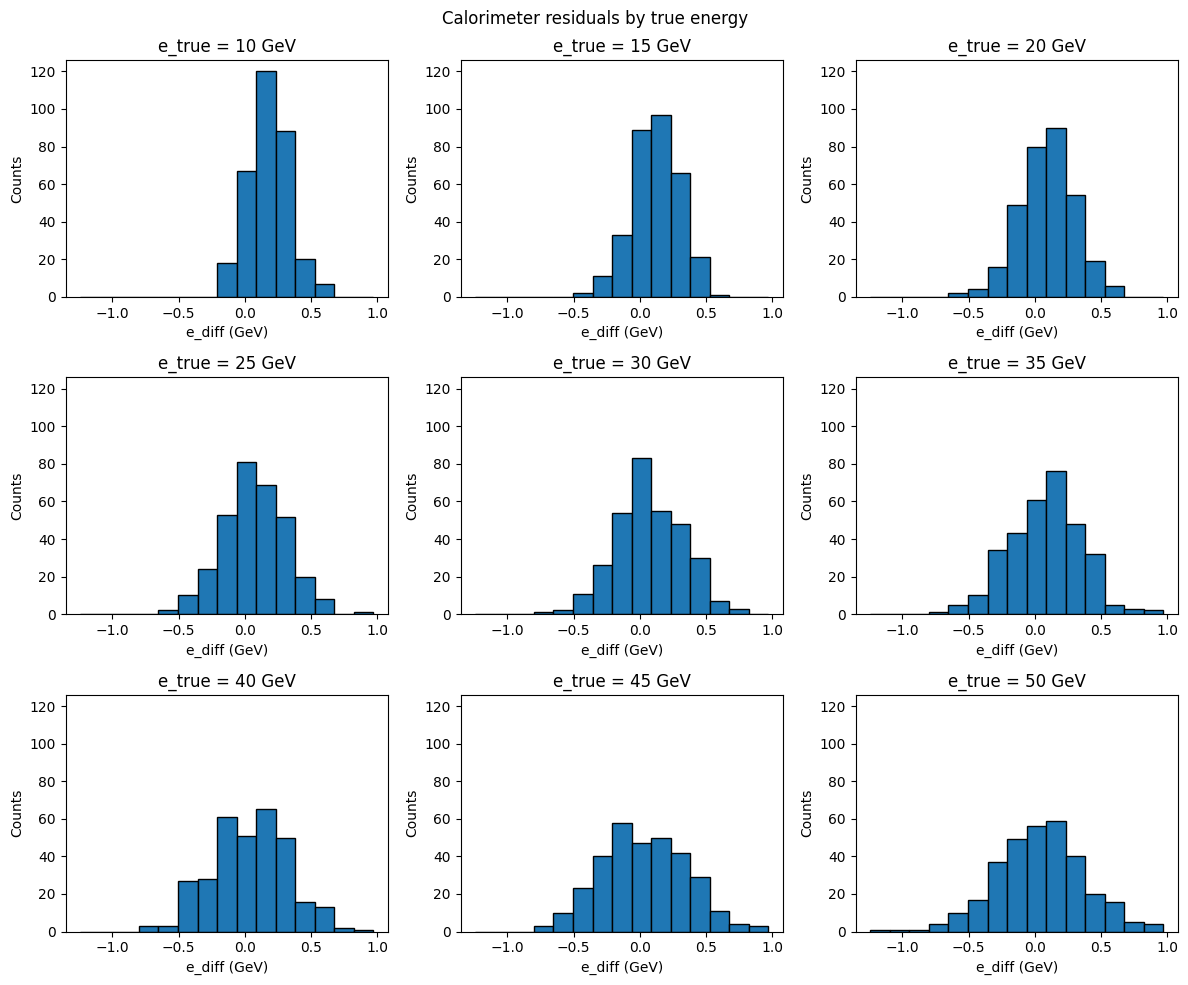

In [24]:
df_data = pd.read_csv('data_calorimeter.csv') #this is in the same directory as the notebook
df_data['e_diff'] = df_data['e_measured'] - df_data['e_true']

energies = sorted(df_data['e_true'].unique()) #could just hardcode them as we know what they are, but this is a nicer way
bins = np.linspace(df_data['e_diff'].min(), df_data['e_diff'].max(), 16)

fig,axes = plt.subplots(3,3, figsize=(12,10), sharex=True, sharey=True) #make a 3x3 grid for all 9 plots we need
for ax, E in zip(axes.flat, energies):
    diffs = df_data.loc[df_data['e_true'] == E, 'e_diff']
    ax.hist(diffs, bins=bins, color='C0', edgecolor='black')
    ax.set_title(f"e_true = {E} GeV")
    ax.set_xlabel("e_diff (GeV)")
    ax.set_ylabel("Counts")
    ax.tick_params(labelbottom=True, labelleft=True)

    

fig.suptitle("Calorimeter residuals by true energy")
plt.tight_layout()
plt.show()


##### (ii) [2 marks] We can assume that due to the resolution of calorimeter, e_diff will be distributed as a Gaussian distribution.... For each value of e_true find the MLE mu and sigma.

So inital thoughts are that we could do this in a closed-form/analytical way. This is because for a Gaussian, MLEs are the sample mean and the population s.d

$ \hat{\mu}$ = mean(e_diff) \
$ \hat{\sigma}$ = sqrt(mean((e_diff - u_hat)^2)) \
so we wouldn't need an optimizer, but given the question suggests doing it numerically let's proceed with that.

- Assumption: For each e_true, the residuals e_diff follow a Gaussian with mean μ and width σ.
- We perform an unbinned numerical MLE by minimizing the negative log-likelihood:
  NLL(μ, σ) = 0.5 * Σ_i [ ((x_i − μ)/σ)^2 + ln(2πσ^2) ], with σ > 0.
- For each e_true, initialize μ at the sample mean and σ at the sample std, then minimize using SciPy.

In [ ]:
# 1.1 (ii) – Numerical MLE (Gaussian) per e_true using SciPy

from scipy.optimize import minimize as opt_minimize

#negative log-likelihood function for Gaussian (just like we did in class)
def nll_gauss(theta, x):
    mu, sigma = theta
    return 0.5 * np.sum(((x - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))

energies = sorted(df_data['e_true'].unique())
rows = []

for E in energies:
    x = df_data.loc[df_data['e_true'] == E, 'e_diff'].values #just like in part (i)
    mu0 = x.mean()
    sig0 = x.std(ddof=0) if x.std(ddof=0) > 0 else 1e-3 #keeping our sigma > 0, else we get issues when minimizing
    #ddof = 0 b/c we're dividing by N not N-1 for sample variance
    res = opt_minimize(
        nll_gauss,
        x0=np.array([mu0, sig0]),
        args=(x,),
        method='L-BFGS-B',
        bounds=[(None, None), (1e-6, None)]
    )
    mu_hat, sigma_hat = res.x
    rows.append({'e_true': E, 'mu_hat': mu_hat, 'sigma_hat': sigma_hat})

summary_mle = pd.DataFrame(rows).sort_values('e_true')
print(summary_mle.round(6).to_string(index=False))

 e_true   mu_hat  sigma_hat
     10 0.181922   0.151432
     15 0.120331   0.176225
     20 0.094020   0.204680
     25 0.075402   0.235988
     30 0.068854   0.250193
     35 0.083918   0.265224
     40 0.037715   0.284078
     45 0.028788   0.316492
     50 0.041381   0.337155


so we see our u_hat is small and remains positive across all the energies. Further our sigma_hat grows with energy, which makes sense.

##### (iii) [2 marks] Plot our Gaussian from the previous parts on top of the histograms. Also plot the ratio of the MLE to the value of e_true

initially tried a few different ways to set bins value.
- just some int like 50 (and then kept that consistent with the gaussian plot)
- tried to use linspace between the max/min value we had for e_diff
- finally looked online and found this https://stats.stackexchange.com/questions/798/calculating-optimal-number-of-bins-in-a-histogram, they suggested this Freedman-Diaconis method, which is what I thought I'd try here

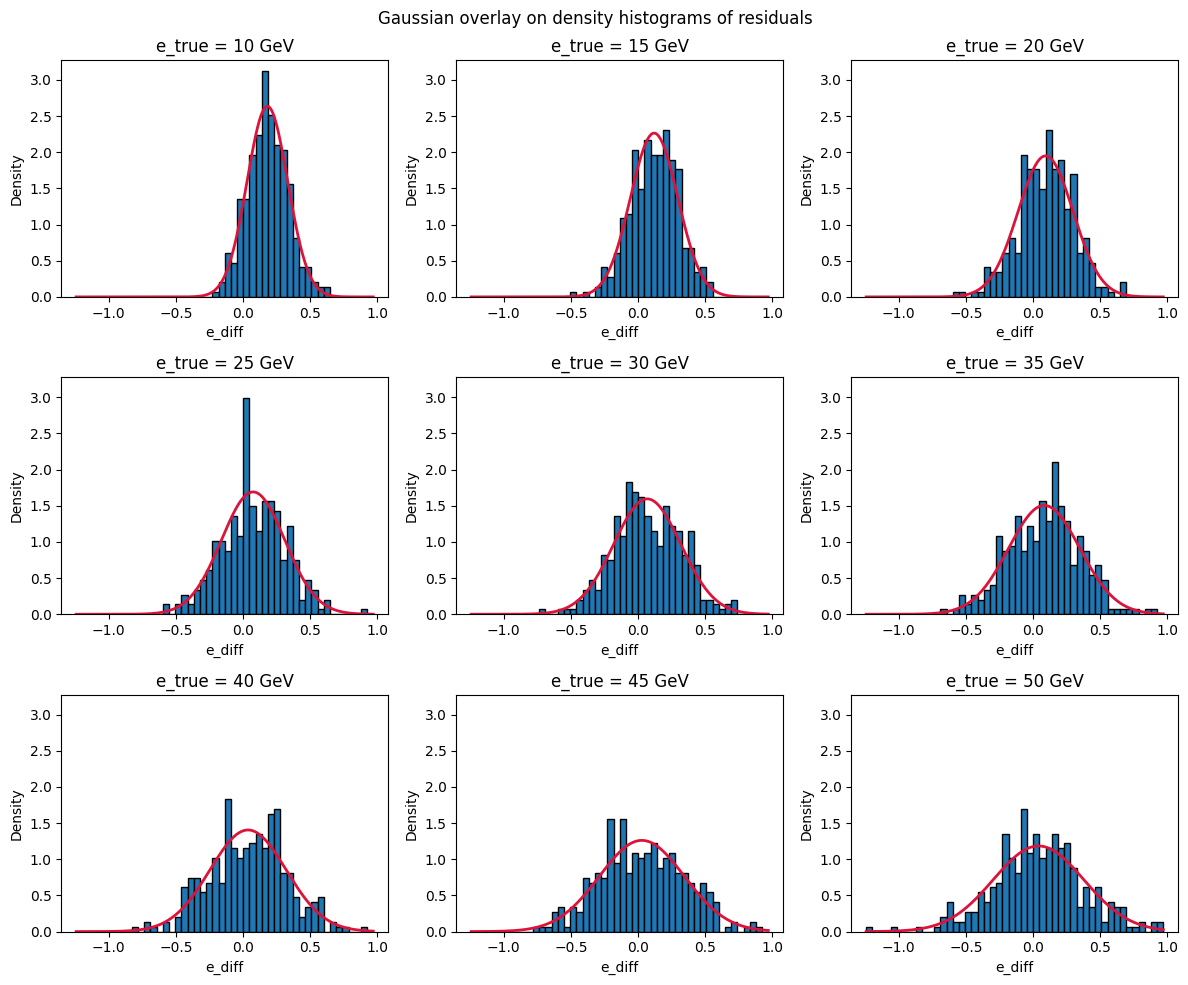

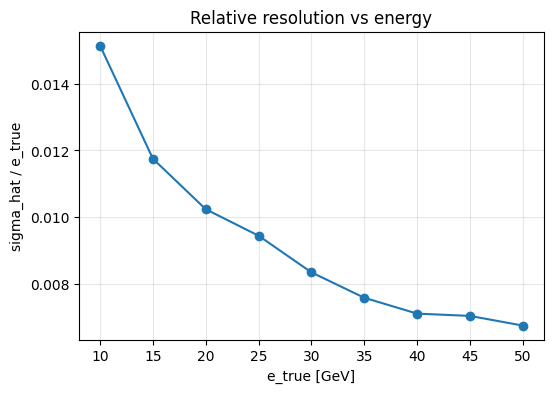

In [ ]:
# 1.1 (iii) – overlay Gaussian on density histograms + plot sigma_hat / e_true

energies = sorted(df_data['e_true'].unique())

# Freedman–Diaconis global binning
gmin, gmax = df_data['e_diff'].min(), df_data['e_diff'].max()
q25, q75 = np.percentile(df_data['e_diff'], [25, 75])
iqr = q75 - q25
n = len(df_data)
h = 2 * iqr * (n ** (-1/3))
if h <= 0:
    nbins = 50
else:
    nbins = max(int(np.ceil((gmax - gmin) / h)), 10)
bins = np.linspace(gmin, gmax, nbins)

fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
for ax, E in zip(axes.flat, energies):
    diffs = df_data.loc[df_data['e_true'] == E, 'e_diff'].values
    row = summary_mle.loc[summary_mle['e_true'] == E].iloc[0]
    mu, sigma = row['mu_hat'], row['sigma_hat']

    # Density histogram
    ax.hist(diffs, bins=bins, density=True, edgecolor='black')

    # Gaussian PDF overlay (density)
    x = np.linspace(gmin, gmax, 400)
    y = norm.pdf(x, loc=mu, scale=sigma)
    ax.plot(x, y, color='crimson', lw=2)

    ax.set_title(f"e_true = {E} GeV")
    ax.set_xlabel("e_diff")
    ax.set_ylabel("Density")
    ax.tick_params(labelbottom=True, labelleft=True)

fig.suptitle("Gaussian overlay on density histograms of residuals")
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,4))
plt.plot(summary_mle['e_true'], summary_mle['sigma_hat'] / summary_mle['e_true'], 'o-')
plt.xlabel("e_true [GeV]")
plt.ylabel("sigma_hat / e_true")
plt.title("Relative resolution vs energy")
plt.grid(True, alpha=0.3)
plt.show()

So what do we see ?

The Gaussian overlays describe the residuals well at all energies b/c we can see the shapes match the histograms closely.\
The fitted widths grow with E and the relative resolution decreases with E


##### (iv) [2 marks] We now write a new likelihood function L() which combined the likelihood over all events and energies.

So we keep the vector of parameters of mu as free (nuisance) for each e_true, but we constraint the width to S * sqrt(E_true)

Minimize NLL w.r.t. S and all mu_E. Initialize S=0.02 and mu_E as the sample means.

In [ ]:
# 1.1 (iv) – Global MLE of S

from scipy.optimize import minimize as opt_minimize
import numpy as np
import pandas as pd

energies = sorted(df_data['e_true'].unique())

# Initial guesses: S ~ 0.02 using the hint
S0 = 0.02
mu0 = [df_data.loc[df_data['e_true'] == E, 'e_diff'].mean() for E in energies]
theta0 = np.array([np.log(S0)] + mu0)

def nll_stochastic(theta):
    lam = theta[0]
    S = np.exp(lam)           # enforce S > 0, S must be positive. b/c e^X is always >0 for Real X
    mus = theta[1:]
    total = 0.0
    for j, E in enumerate(energies):
        x = df_data.loc[df_data['e_true'] == E, 'e_diff'].values
        sigma = S * np.sqrt(E)
        mu = mus[j]
        total += 0.5 * np.sum(((x - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
    return total

res = opt_minimize(nll_stochastic, x0=theta0, method='BFGS')
S_hat = np.exp(res.x[0])
print(f"S_hat = {S_hat:.6f}")

S_hat = 0.046307


##### (v) [2 marks] Ge the s.d for our estimator S. We do this using bootstrapping on the original dataset. Do < 100 samples

In [ ]:
# 1.1 (v) – Bootstrap s.d. for S

B = 100
rng = np.random.default_rng(6067948) #My CID !!
S_boot = []

for b in range(B):
    idx = rng.integers(0, len(df_data), len(df_data)) #draw out a len(df_data) sample section
    df_boot = df_data.iloc[idx].reset_index(drop=True)

    mu0 = [df_boot.loc[df_boot['e_true'] == E, 'e_diff'].mean() for E in energies]
    theta0 = np.array([np.log(0.02)] + mu0)

    # NLL
    def nll_boot(theta):
        lam = theta[0]
        S = np.exp(lam)
        mus = theta[1:]
        total = 0.0
        for j, E in enumerate(energies):
            x = df_boot.loc[df_boot['e_true'] == E, 'e_diff'].values
            sigma = S * np.sqrt(E)
            mu = mus[j]
            total += 0.5 * np.sum(((x - mu) / sigma) ** 2 + np.log(2 * np.pi * sigma ** 2))
        return total

    res = opt_minimize(nll_boot, x0=theta0, method='BFGS')
    S_boot.append(np.exp(res.x[0]))

S_boot = np.array(S_boot) #convert the list into a numpy array
S_boot_sd = S_boot.std(ddof=1) #this allows us to get the std from it
print(f"Bootstrap std(S) with B={B}: {S_boot_sd:.6f}")

Bootstrap std(S) with B=100: 0.000554


So we get S_hat = 0.046307±0.000554

##### (vi) [1 mark] Make a plot of the function S* sqrt(e_true) / e_true overlaid on the fits from part 1.

The fits from part 1 would mean the histograms, but I also thought it would make sense to have the curve we plotted in part 3. So included both

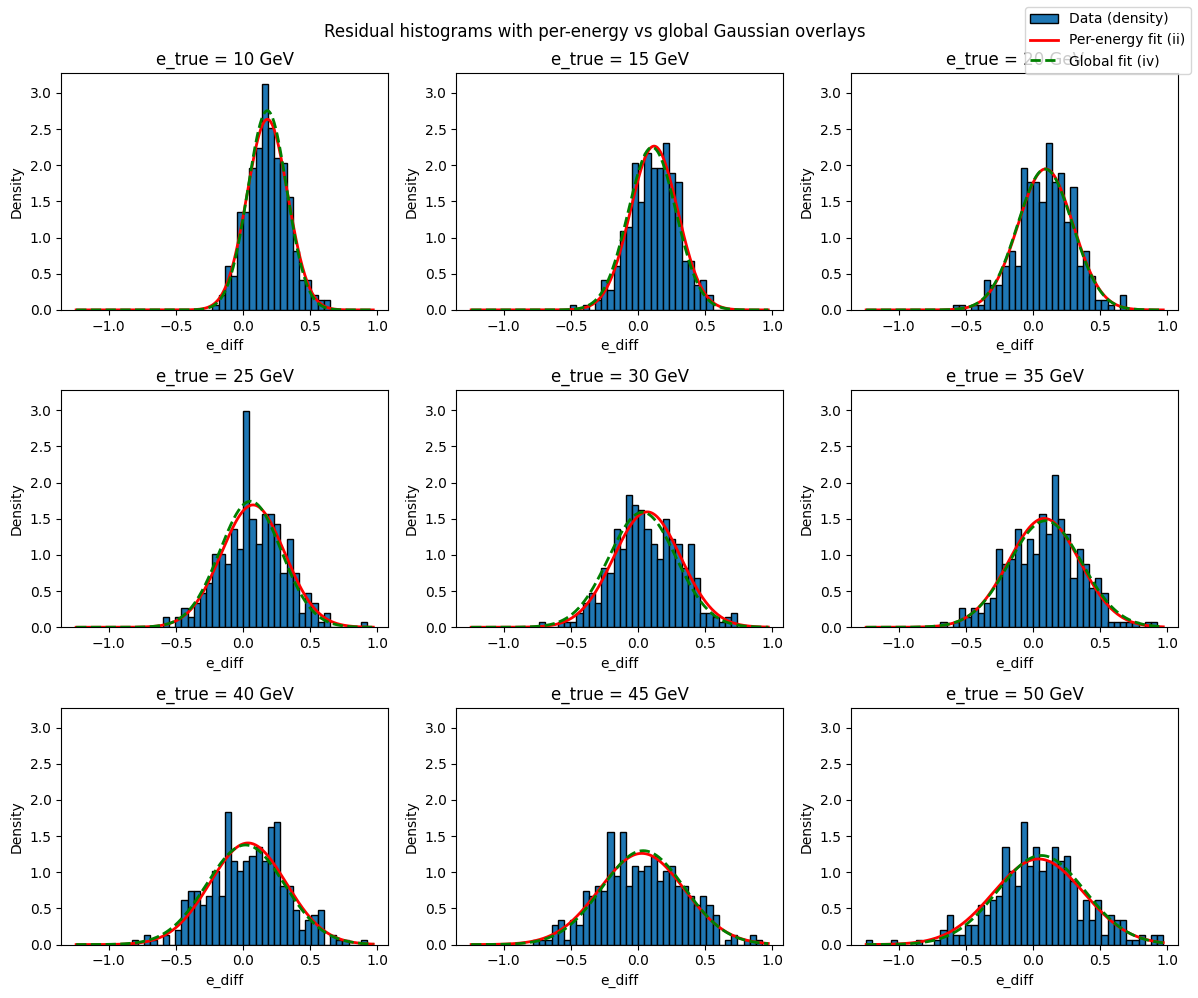

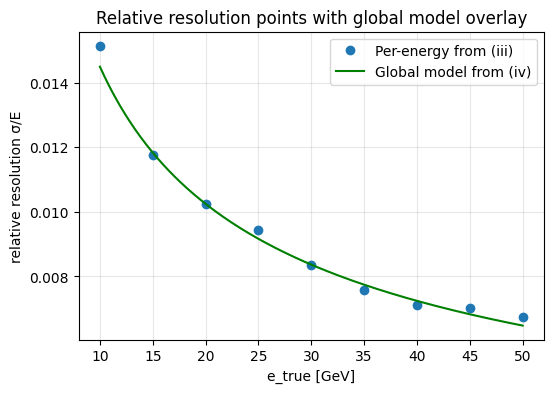

In [48]:
# 1.1 (vi) – Overlay global fit (part iv) with per-energy fits (part iii)

# Extract global parameters from part (iv)
S_hat = np.exp(res.x[0])
mus_global = res.x[1:]                 # one μ_E per energy, same order as the energies list we used before
mu_g_map = {E: mu for E, mu in zip(energies, mus_global)}

# Common x-range and bins (Doing it with the FD way again with iqr etc..)
gmin, gmax = df_data['e_diff'].min(), df_data['e_diff'].max()
q25, q75 = np.percentile(df_data['e_diff'], [25, 75])
iqr = q75 - q25
n = len(df_data)
h = 2 * iqr * (n ** (-1/3))
nbins = 50 if h <= 0 else max(int(np.ceil((gmax - gmin) / h)), 10)
bins = np.linspace(gmin, gmax, nbins)
x_plot = np.linspace(gmin, gmax, 400)

# A) Histograms with two overlays, per-energy (ii) and global model (iv)
fig, axes = plt.subplots(3, 3, figsize=(12, 10), sharex=True, sharey=True)
for ax, E in zip(axes.flat, energies):
    diffs = df_data.loc[df_data['e_true'] == E, 'e_diff'].values

    # Per-energy from part (ii)
    row = summary_mle.loc[summary_mle['e_true'] == E].iloc[0]
    mu_ind, sig_ind = row['mu_hat'], row['sigma_hat']

    # Global model from part (iv)
    mu_glob = mu_g_map[E]
    sig_glob = S_hat * np.sqrt(E)

    # Histogram
    ax.hist(diffs, bins=bins, density=True, edgecolor='black', label='Data (density)')

    # Overlays
    ax.plot(x_plot, norm.pdf(x_plot, loc=mu_ind,  scale=sig_ind),  color='red', lw=2, label='Per-energy fit (ii)')
    ax.plot(x_plot, norm.pdf(x_plot, loc=mu_glob, scale=sig_glob), color='green', lw=2, ls='--', label='Global fit (iv)')

    ax.set_title(f"e_true = {E} GeV")
    ax.set_xlabel("e_diff")
    ax.set_ylabel("Density")
    ax.tick_params(labelbottom=True, labelleft=True)

# All the legends
handles, labels = axes.flat[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right')
fig.suptitle("Residual histograms with per-energy vs global Gaussian overlays")
plt.tight_layout()
plt.show()

# B) Plotting the curve from part (iii) overlayed 
plt.figure(figsize=(6,4))
Epts = np.array(energies, float)
plt.plot(summary_mle['e_true'], summary_mle['sigma_hat'] / summary_mle['e_true'], 'o', label='Per-energy from (iii)')
Egrid = np.linspace(Epts.min(), Epts.max(), 300)
plt.plot(Egrid, S_hat / np.sqrt(Egrid), '-', color='green', label='Global model from (iv)')

plt.xlabel("e_true [GeV]")
plt.ylabel("relative resolution σ/E")
plt.title("Relative resolution points with global model overlay")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

So as we can see in the plots above the two fits align well. So we can say that the single stochastic parameter S captures the calorimeter resolution across energies pretty well. The global fit is consistent with and evidently as good as the per-energy fits.